In [1]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from PIL import Image  # For image processing
import numpy as np  # For numerical operations
import pandas as pd 
import matplotlib.pyplot as plt    
import seaborn as sns
import random 
import cv2
import glob
from numpy.random import seed
seed(42)
random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
# Path to the dataset in Kaggle
dataset_path = '/kaggle/input/labeled-chest-xray-images/chest_xray'

# Load train and test dataset
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Check if the dataset path exists
if os.path.exists(train_path) and os.path.exists(test_path):
    print("Dataset found! Train and Test sets are available. Proceeding with preprocessing...")

    # Check the number of images in train and test data
    num_train_images = sum([len(files) for _, _, files in os.walk(train_path)])
    num_test_images = sum([len(files) for _, _, files in os.walk(test_path)])
    
    print(f"number of train images: {num_train_images}")
    print(f"number of test images: {num_test_images}")
else:
    if not os.path.exists(train_path):
        print(f"Train dataset not found at {train_path}. Please check the folder structure.")
    if not os.path.exists(test_path):
        print(f"Test dataset not found at {test_path}. Please check the folder structure.")


Dataset found! Train and Test sets are available. Proceeding with preprocessing...
number of train images: 5232
number of test images: 624


In [5]:
# Function to check the number of images in each category
def count_images_per_class(data_path):
    class_counts = {}
    
    for root, _, files in os.walk(data_path):
        if root == data_path:
            continue  

        class_name = os.path.basename(root)  
        num_images = len(files)  
        class_counts[class_name] = num_images 
    
    return class_counts

In [6]:
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

print("Number of images for each class (Train):")
for class_name, count in train_counts.items():
    print(f" {class_name}: {count}")

print("Number of images for each class (Test):")
for class_name, count in test_counts.items():
    print(f" {class_name}: {count}")

Number of images for each class (Train):
 PNEUMONIA: 3883
 NORMAL: 1349
Number of images for each class (Test):
 PNEUMONIA: 390
 NORMAL: 234


There is a large difference between the number of images in the pneumonia and normal categories, leading to imbalanced data.

In [7]:
# List all files and folders in the dataset
#for dirname, _, filenames in os.walk(dataset_path):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [8]:
# Directory to save resized images
output_path = '/kaggle/working/preprocessed_images'
os.makedirs(output_path, exist_ok=True)

In [9]:
dataset_paths = {'train': train_path, 'test': test_path}

for dataset_type, dataset_path in dataset_paths.items():
    for class_name in os.listdir(dataset_path):  
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        

        output_class_path = os.path.join(output_path, dataset_type, class_name)
        os.makedirs(output_class_path, exist_ok=True)

In [10]:
# Function to check if an image is corrupted
def is_image_corrupted(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Verifies if an image is corrupted
        return False  # No error, so it's not corrupted
    except (IOError, SyntaxError) as e:
        return True  # Corrupted image

In [11]:
datasets_paths = [train_path, test_path]
corrupted_images = []

for dataset_path in datasets_paths:
    print(f"\n Searching for corrupted images in: {dataset_path}")
    
    for class_folder in os.listdir(dataset_path):  # Normal, Pneumonia
        class_path = os.path.join(dataset_path, class_folder)
        
        if os.path.isdir(class_path):  # Ensure that it is a folder, not a file
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if is_image_corrupted(img_path):
                    print(f"corrupted image: {img_path}")
                    corrupted_images.append(img_path)

# the number of corrupted images
print(f"\n The number of corrupted images in train and test: {len(corrupted_images)}")


 Searching for corrupted images in: /kaggle/input/labeled-chest-xray-images/chest_xray/train

 Searching for corrupted images in: /kaggle/input/labeled-chest-xray-images/chest_xray/test

 The number of corrupted images in train and test: 0


In [12]:
for dataset_type, dataset_path in dataset_paths.items():
    for class_name in os.listdir(dataset_path):  # (Normal/Pneumonia)
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):  
            continue
        
        output_class_path = os.path.join(output_path, dataset_type, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for filename in os.listdir(class_path):  
            if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(class_path, filename)
                
                if is_image_corrupted(img_path):
                    print(f"Skipping corrupted image: {filename}")
                    continue

                try:
                    img = Image.open(img_path)
                   
                    img_resized = img.resize((128, 128))
                    
                    img_array = np.array(img_resized) / 255.0

                    if img_array.shape[0] < 128 or img_array.shape[1] < 128:
                        print(f"Skipping low-quality image (too small): {filename}")
                        continue

                    output_file = os.path.join(output_class_path, filename)
                    img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
                    img_normalized.save(output_file)
                    #print(f"Processed and saved: {output_file}")

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

print("Processing complete!")

Processing complete!


show information about this data

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True
)

In [14]:
train_path = '/kaggle/working/preprocessed_images/train' 
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

num_normal = len(os.listdir(normal_path))
num_pneumonia = len(os.listdir(pneumonia_path))

print(f" Normal={num_normal}, Pneumonia={num_pneumonia}")

 Normal=1349, Pneumonia=3883


In [15]:
normal_images = []
for img_name in os.listdir(normal_path):
    img_path = os.path.join(normal_path, img_name)
    img = load_img(img_path) 
    img_array = img_to_array(img) 
    normal_images.append(img_array)
    
normal_images = np.array(normal_images)

In [16]:
#num_augmentations = 3888 - 1340 
#augmented_images = []
#for _ in range(num_augmentations // 32):  
    #augmented_images.append(augmented_data.next())

num_augmentations = num_pneumonia - num_normal
augmented_images = []
datagen_flow = datagen.flow(normal_images, batch_size=32, shuffle=True)
    
for _ in range(num_augmentations // 32 + 1):
    augmented_images.extend(next(datagen_flow)) 
    if len(augmented_images) >= num_augmentations:
        break

In [17]:
#augmented_data = datagen.flow(normal_images, batch_size=32, shuffle=True)

In [18]:
#augmented_images = np.vstack(augmented_images)
augmented_images = np.array(augmented_images[:num_augmentations])

In [19]:
#train_images_balanced = np.concatenate([train_images, augmented_images], axis=0)
#train_labels_balanced = np.concatenate([train_labels, np.array(["NORMAL"] * len(augmented_images))], axis=0)
train_images_balanced = np.concatenate([normal_images, augmented_images], axis=0)
train_labels_balanced = np.array(["NORMAL"] * len(train_images_balanced))

In [20]:
print(f"Balanced dataset: Normal={len(train_images_balanced)}, Pneumonia={num_pneumonia}")

Balanced dataset: Normal=3882, Pneumonia=3883


In [21]:
# Function to prepare DataFrame 
def prepare_dataframe(dataset_path):
    image_paths = []
    classes = []

    for class_name in os.listdir(dataset_path):  # NORMAL, PNEUMONIA
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                classes.append(class_name)

    # Create and return DataFrame
    return pd.DataFrame({
        "class": classes,
        "image": image_paths
    })

# Paths to dataset
train_path = '/kaggle/input/labeled-chest-xray-images/chest_xray/train'
test_path = '/kaggle/input/labeled-chest-xray-images/chest_xray/test'

# Prepare DataFrames
df_train = prepare_dataframe(train_path)
df_test = prepare_dataframe(test_path)


# Display DataFrames
print("Train DataFrame:")
print(df_train.head())
print("\nTest DataFrame:")
print(df_test.head())

Train DataFrame:
       class                                              image
0  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
1  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
2  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
3  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
4  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...

Test DataFrame:
       class                                              image
0  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
1  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
2  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
3  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
4  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...


Exploring The Data 

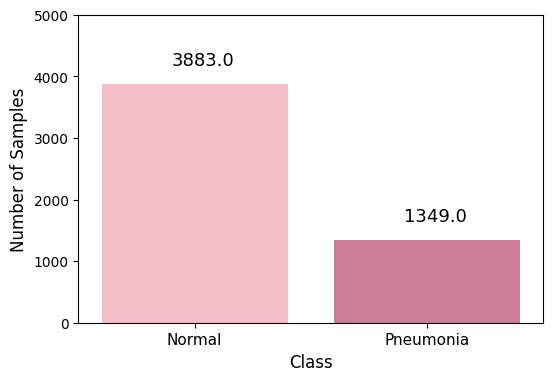

In [22]:
plt.figure(figsize=(6,4))

axis = sns.countplot(x='class', data=df_train, palette=["#FFB6C1", "#DB7093"])

plt.xlabel("Class", fontsize= 12)
plt.ylabel("Number of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in axis.patches:
    axis.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()


In [23]:
print(df_train['class'].value_counts())

class
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64


In [24]:
train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [25]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

Train Set - Normal


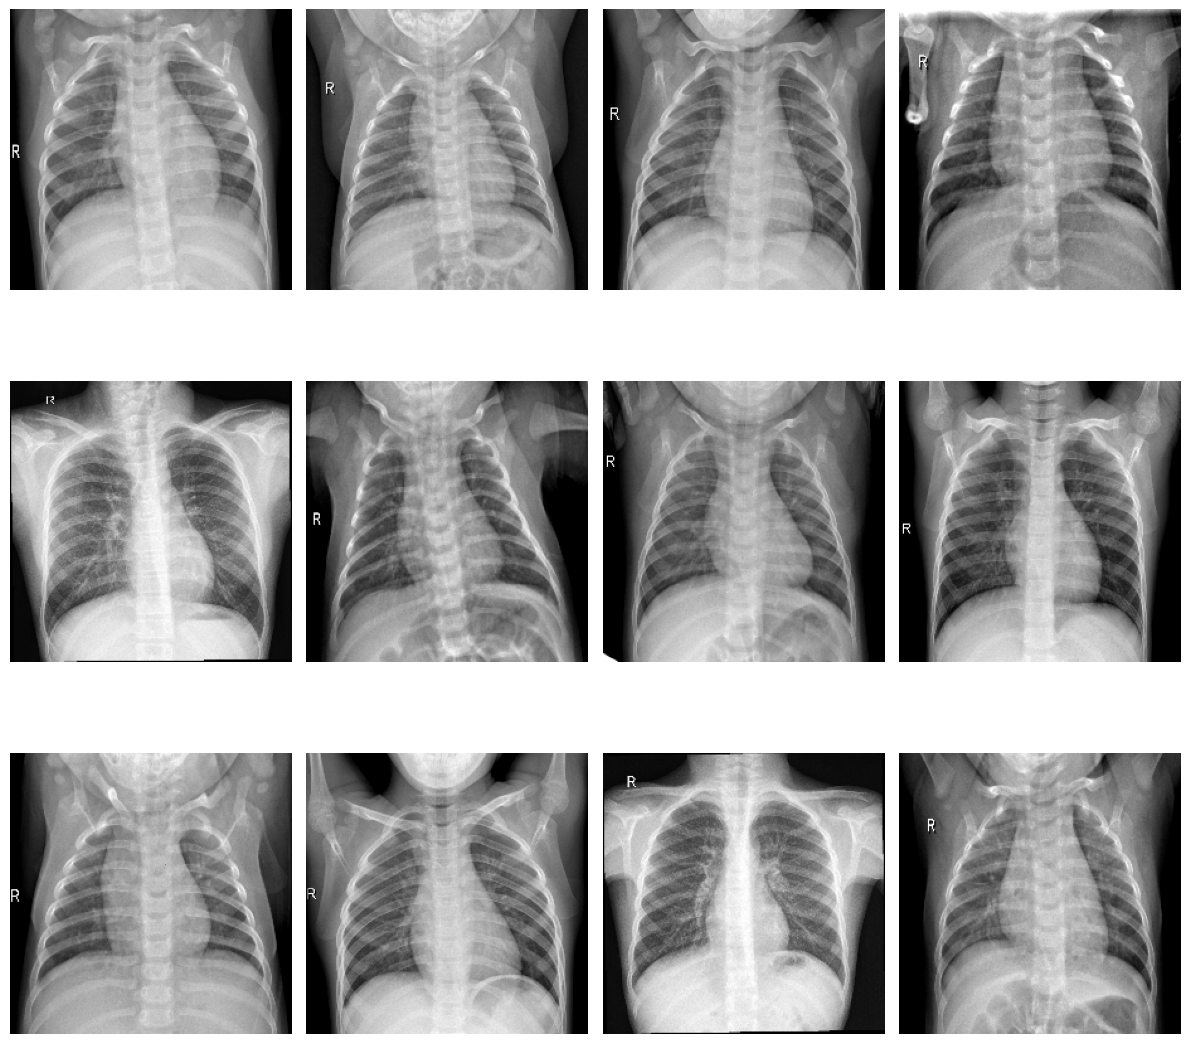

In [26]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


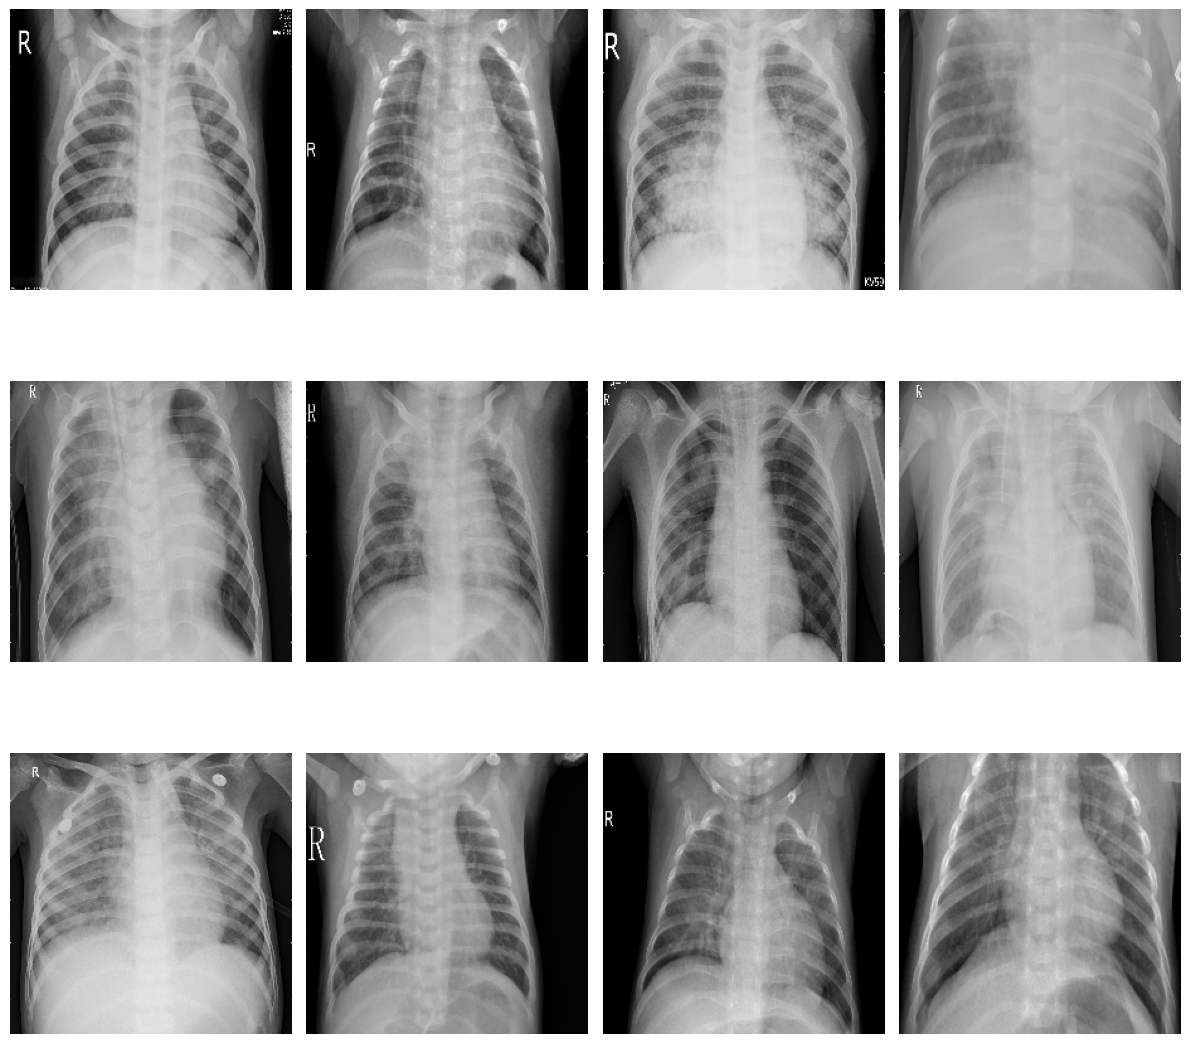

In [27]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


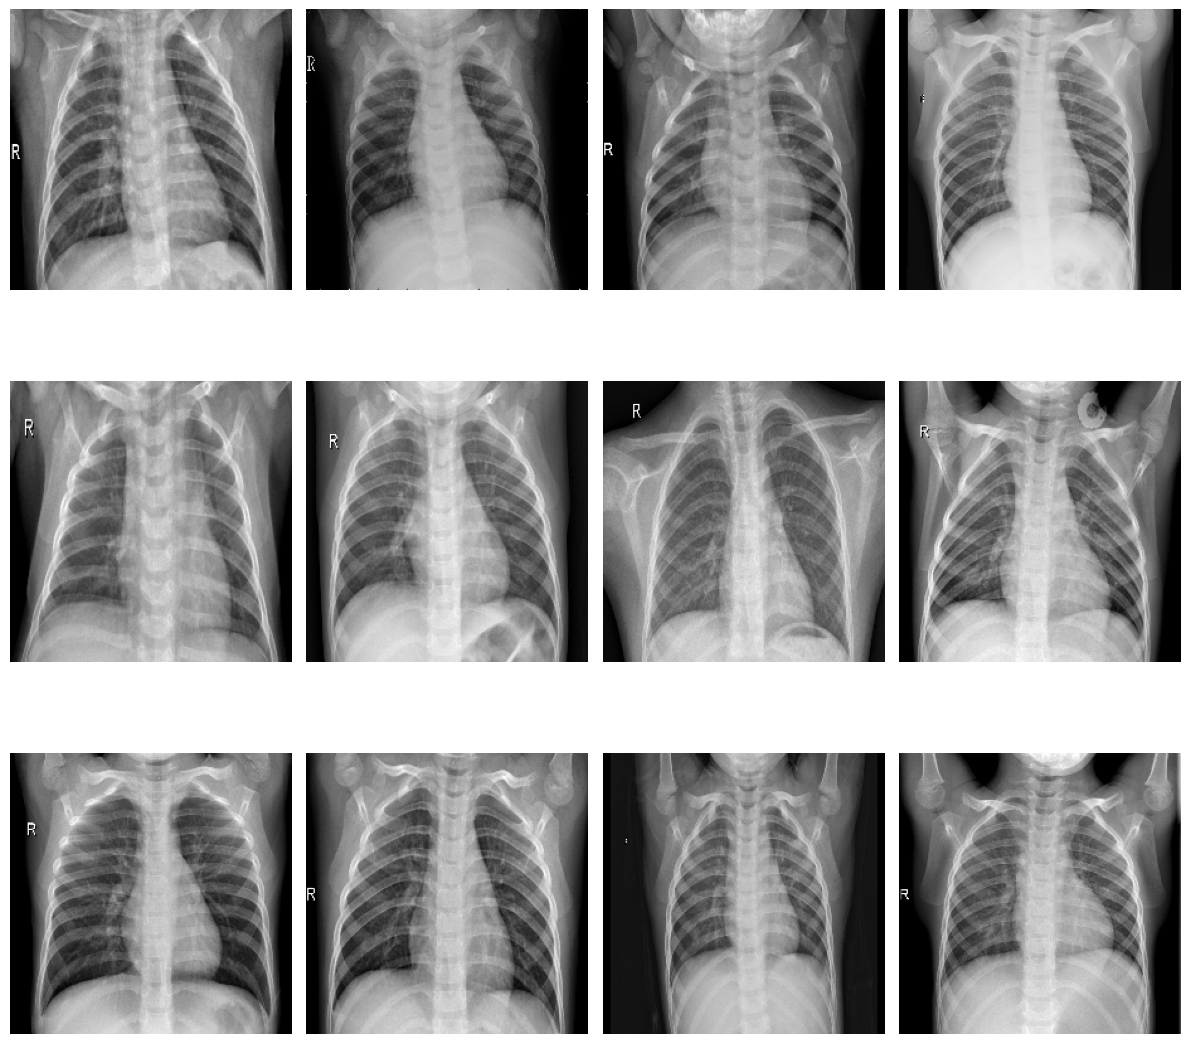

In [28]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


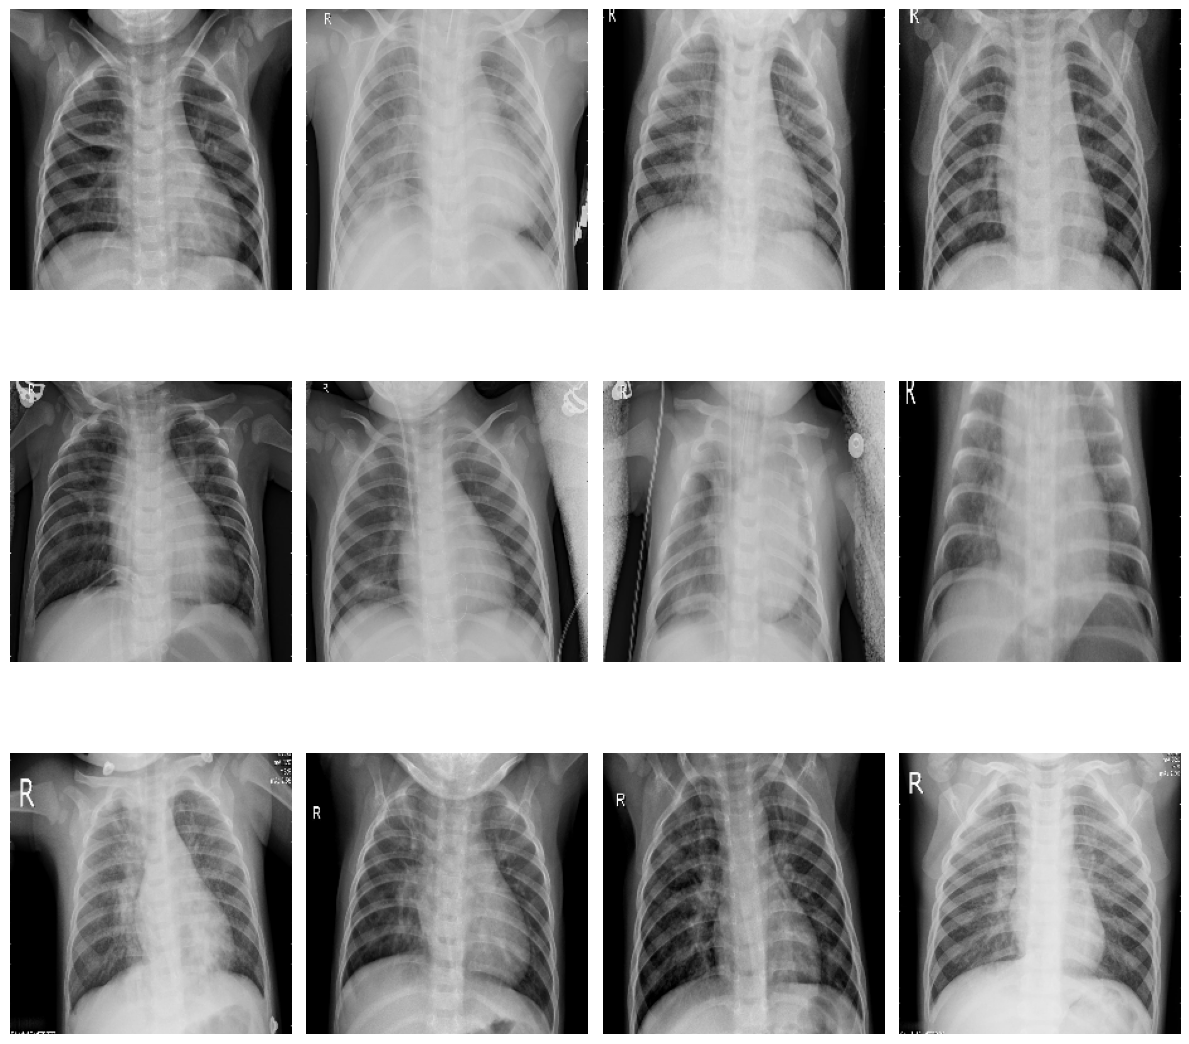

In [29]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

***Preparing The Data*** 

we need to create a validation set.To do that,we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [30]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [31]:
train_df 

class                                              image
3566  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
2866  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
2681  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
1199     Normal  /kaggle/input/labeled-chest-xray-images/chest_...
4619  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
...         ...                                                ...
3476  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
678      Normal  /kaggle/input/labeled-chest-xray-images/chest_...
1560  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
2769  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
4881  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...

[4185 rows x 2 columns]

In [32]:
val_df

class                                              image
2945  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
4878  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
3177  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
972      Normal  /kaggle/input/labeled-chest-xray-images/chest_...
3059  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
...         ...                                                ...
253      Normal  /kaggle/input/labeled-chest-xray-images/chest_...
4315  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
687      Normal  /kaggle/input/labeled-chest-xray-images/chest_...
3417  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...
3745  Pneumonia  /kaggle/input/labeled-chest-xray-images/chest_...

[1047 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models.

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

In [33]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


**CNN Model**

In [34]:
#callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Defining our first model ‘from scratch’ and see how it performs

In [35]:
def get_model():
    
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # 1st block
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # 2nd block
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # 3rd block
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [36]:
import keras

# Assuming get_model() is defined elsewhere
keras.backend.clear_session()

model = get_model()
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['binary_accuracy']  # Wrap 'binary_accuracy' in a list
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │              

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [52]:
history = model.fit(
    ds_train,
    batch_size=BATCH,
    epochs=50,
    validation_data=ds_val,
    callbacks=[early_stopping, plateau],
    steps_per_epoch=int(len(train_df) / BATCH),  
    validation_steps=int(len(val_df) / BATCH)   
)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - binary_accuracy: 0.8564 - loss: 0.3204 - val_binary_accuracy: 0.7422 - val_loss: 1.7265 - learning_rate: 1.2000e-06
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8750 - loss: 0.3565 - val_binary_accuracy: 0.7391 - val_loss: 1.7342 - learning_rate: 1.2000e-06
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - binary_accuracy: 0.8621 - loss: 0.3107 - val_binary_accuracy: 0.7412 - val_loss: 1.4888 - learning_rate: 1.2000e-06
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - binary_accuracy: 0.8750 - loss: 0.2674 - val_binary_accuracy: 0.7826 - val_loss: 1.2456 - learning_rate: 1.2000e-06
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - binary_accuracy: 0.8562 - loss: 0.3209 - val_binary_accuracy: 0.7451 - val_loss: 0.9106 - learning_rate: 1.2000e-06
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8750 - loss: 0.2630 - val_binary_accuracy: 0.6522 - val_loss: 1.1708 - le

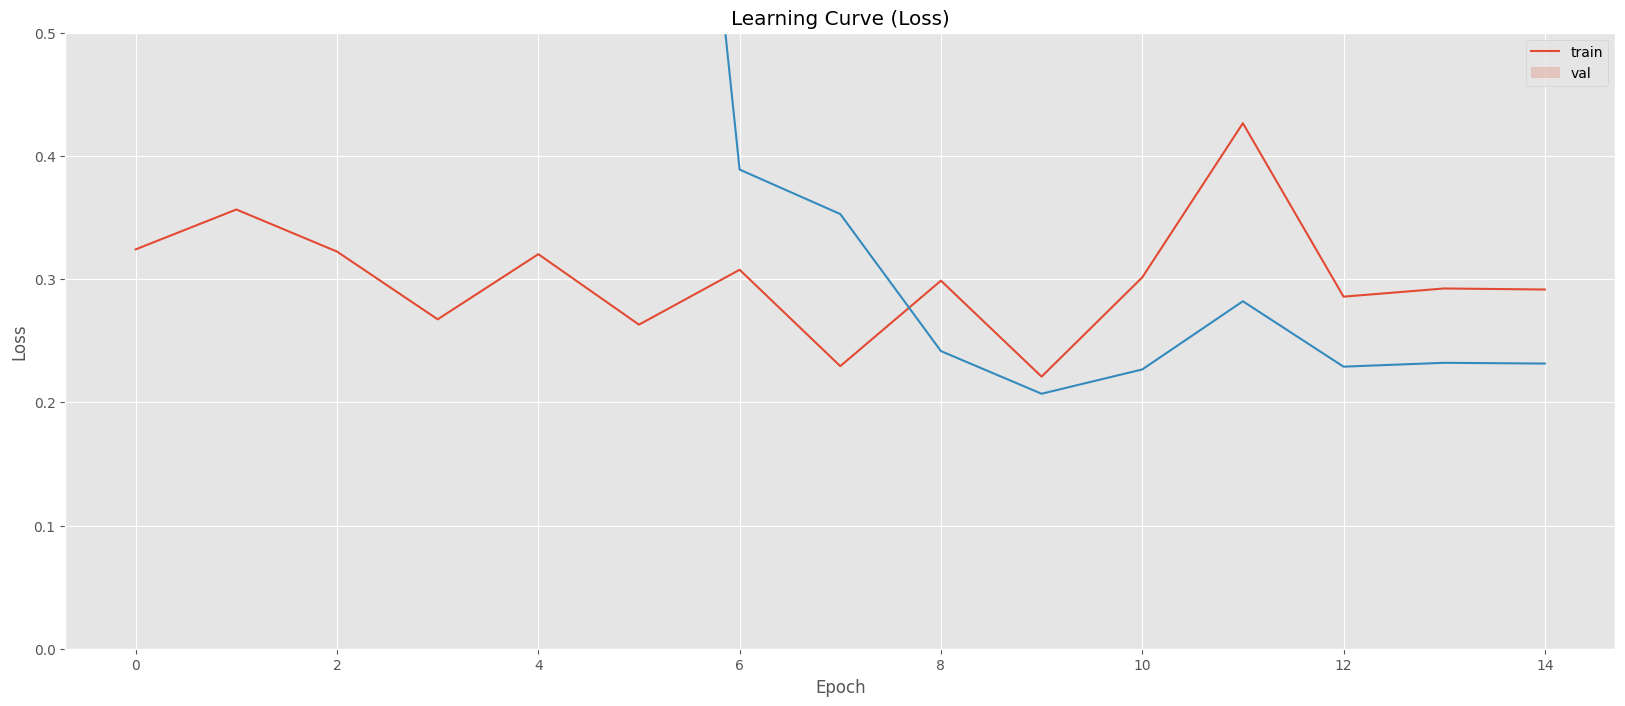

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

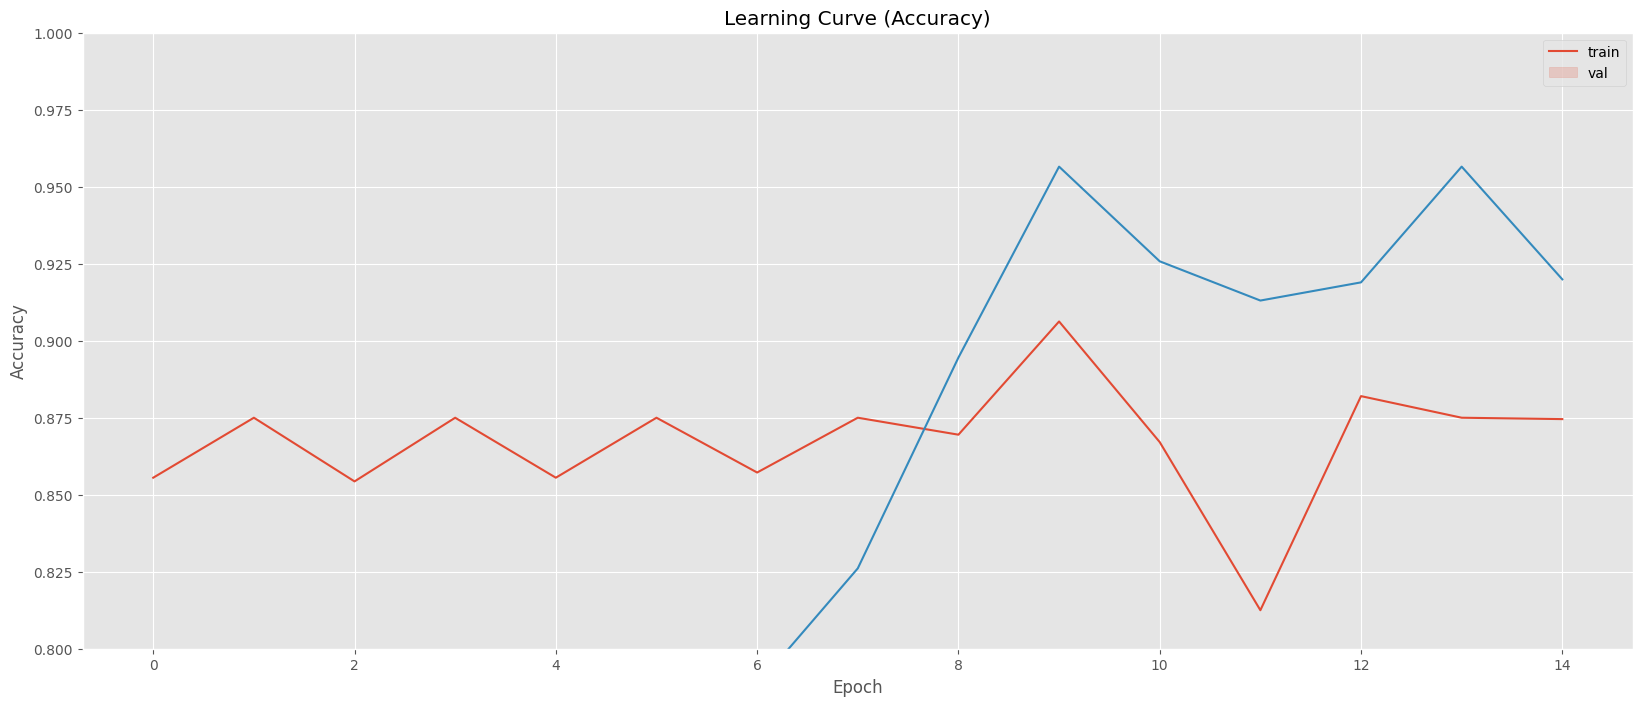

In [54]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [57]:
score = model.evaluate(ds_val, steps=int(len(val_df) / BATCH), verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.24043738842010498
Val accuracy: 0.896484375


In [58]:
model.save('/kaggle/working/cnn_model.h5')

In [ ]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/labeled-chest-xray-images/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

In [ ]:
class_labels = train_generator.class_indices

In [ ]:
class_labels

In [ ]:
class_name = {value:key for (key, value) in class_labels.items()}

In [ ]:
class_name

In [ ]:
vgg19_weights_path = "C:/Users/marya/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"


In [51]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x) 


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution